# Simulation experiment for detection thresholds for variant calling

This notebook is to get detection thresholds for the limit of the variant calling based on: 

1. Read depth
2. Error rate
3. Number of mutations


Also optionaly get the time it takes to complete experiments per sequence length.


```
>lcl|NC_000913.3_cds_NP_414902.1_362 [gene=tauD] [locus_tag=b0368] [db_xref=UniProtKB/Swiss-Prot:P37610] [protein=taurine dioxygenase] [protein_id=NP_414902.1] [location=387795..388646] [gbkey=CDS]
```

From: ecoli_GCF_000005845.2_ASM584v2_cds_from_genomic.fna
and >NP_414902.1 taurine dioxygenase [Escherichia coli str. K-12 substr. MG1655]



In [5]:
import pandas as pd
# Visualisation things to make the figures look nice
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sciutil import SciUtil


data_dir = 'data/'
fig_dir = 'figures/'


plt.rcParams['svg.fonttype'] = 'none'
axis_line_width = 1.0
axis_font_size = 12
title_font_size = 12
label_font_size = 10
figsize = (5, 4) # Figure size
font = 'Arial'
style = 'ticks'
font_family = 'sans-serif'

# Create a figure with 2x2 subplots
sns.set_style("whitegrid")
cmap = 'viridis'
palette = sns.color_palette("viridis", as_cmap=True)
sns.set_palette(cmap)

sns.set(rc={'figure.figsize': figsize, 'font.family': font_family,
            'font.sans-serif': font, 'font.size': label_font_size}, style=style)

def set_ax_params(ax):
    ax.tick_params(direction='out', length=2, width=axis_line_width)
    ax.spines['bottom'].set_linewidth(axis_line_width)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(axis_line_width)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=axis_font_size)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.tick_params(labelsize=label_font_size)


u = SciUtil()

# Generate mutations on a "real" sequence
# Decided to choose tauD from Ecoli K12
parent_sequence_aa = 'MSERLSITPLGPYIGAQISGADLTRPLSDNQFEQLYHAVLRHQVVFLRDQAITPQQQRALAQRFGELHIHPVYPHAEGVD\
EIIVLDTHNDNPPDNDNWHTDVTFIETPPAGAILAAKELPSTGGDTLWTSGIAAYEALSVPFRQLLSGLRAEHDFRKSFP\
EYKYRKTEEEHQRWREAVAKNPPLLHPVVRTHPVSGKQALFVNEGFTTRIVDVSEKESEALLSFLFAHITKPEFQVRWRW\
QPNDIAIWDNRVTQHYANADYLPQRRIMHRATILGDKPFYRAG'

parent_sequence = 'ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTT\
AAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGC\
CGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGAC\
GAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAAC\
GCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGG\
CCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCG\
GAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCC\
GGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGA\
GCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGG\
CAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGAT\
AATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA'

# Introduce mutations at a given frequency and an error rate

Test setup:

1. For number of mutations from 1 to the sequence length test mutating each one and correlate this to the p value
2. For sequencing error rates from 0 to 100% make sequences ranging with this and see what the results are for the p value and the error
3. For different sequence lengths also check how sequence length corresponds to the pvalue

In [16]:
from minION import *
from tqdm import tqdm

def make_experiment(run_label, read_depth, sequencing_error_rate, parent_sequence, positions, parent_sequence_aa, amino_acid_to_codon, number_of_wells):
    # Make a full experiment setup
    mutated_sequence = make_ssm_de_experiment(read_depth, sequencing_error_rate, parent_sequence, positions,
                                              parent_sequence_aa, amino_acid_to_codon)
    
    variant_df = get_dummy_plate_df(run_label, 'Well', number_of_wells)  # i.e. 20 - 1 since we don't have the other variant    
    mutant_to_well_df = {}
    current_well = 0
    for mutant in tqdm(mutated_sequence):
        parent_name = 'Parent'
        reads = []
        read_ids = []
        quals = []
        for i, seq in enumerate(mutated_sequence[mutant]):
            read_ids.append(f'read_{i}')
            reads.append(seq)
            quals.append(100)  # Dummy don't need
    
        well_df = make_well_df_from_reads(reads, read_ids, quals)
        rows_all = make_row_from_read_pileup_across_well(well_df, parent_sequence, parent_name)
        well_df = pd.DataFrame(rows_all)
        well_df.columns = ['gene_name', 'position', 'ref', 'most_frequent', 'freq_non_ref', 'total_other',
                           'total_reads', 'p_value', 'percent_most_freq_mutation', 'A', 'p(a)', 'T', 'p(t)', 'G',
                           'p(g)',
                           'C', 'p(c)', 'N', 'p(n)']
        well_df = calculate_mutation_significance_across_well(well_df)
        label, frequency, combined_p_value, mixed_well = get_variant_label_for_well(well_df, 0.5)
        # This should be mutated at 100% - the rate of our sequencing errror
        if verbose:
            u.dp(["label", label, f"frequency", frequency, f"combined_p_value", combined_p_value, "mixed_well", mixed_well])
        mutant_to_well_df[f'{mutant}_{current_well}'] = well_df
        variant_df.at[current_well, "Mixed Well"] = mixed_well
        variant_df.at[current_well, "Variant"] = label
        variant_df.at[current_well, "frequency"] = frequency
        variant_df.at[current_well, "P value"] = combined_p_value
        variant_df.at[current_well, "Well"] = f'Well {current_well}'
        variant_df.at[current_well, "Alignment_count"] = read_depth
        current_well += 1

    # Before returning adjust the pvalues
    variant_df['P adj.'] = multipletests(list(variant_df["P value"].values), alpha=0.05, method='fdr_bh')[1]
    return variant_df

## Experiment 1: Varying the sequencing error rate for a single mutation

--------------------------------------------------------------------------------
       label	A4G_G5C	frequency	1.0	combined_p_value	0.0	mixed_well	False	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4T	frequency	1.0	combined_p_value	7.699811939847464e-291	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
       label	A4G_G5A	frequency	1.0	combined_p_value	0.0	mixed_well	False	       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     label	A4G_G5A_T6A	frequency	1.0	combined_p_value	0.0	mixed_well	False	     
--------------------------------------------------------------------------------
---------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.94' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A4T	frequency	0.99	combined_p_value	6.122779467682517e-124	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A	frequency	0.945	combined_p_value	2.041139164726891e-217	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A_T6A	frequency	0.9199999999999999	combined_p_value	6.447360691900116e-306	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4T_G5T	frequency	0.925	combined_p_value	4.4019459199107594e-208	mixed_well	False	
--------------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9199999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A4T	frequency	0.89	combined_p_value	2.7422411835674805e-72	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A	frequency	0.865	combined_p_value	5.55394736533092e-134	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A_T6A	frequency	0.9266666666666667	combined_p_value	3.666939095741468e-231	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4T_G5T	frequency	0.93	combined_p_value	2.1036635668797696e-158	mixed_well	False	
----------------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.85' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A4T	frequency	0.81	combined_p_value	3.2058836007478527e-45	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A	frequency	0.835	combined_p_value	1.0356592059506724e-94	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A_T6A	frequency	0.84	combined_p_value	8.1544171314214395e-143	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4T_G5T	frequency	0.835	combined_p_value	1.7607794245919877e-94	mixed_well	False	
--------------------------------------------------------------------------------
-

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8049999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A4T	frequency	0.8	combined_p_value	9.307034929380471e-35	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A	frequency	0.78	combined_p_value	1.2691014949444501e-61	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A_T6A	frequency	0.82	combined_p_value	1.4428558767197424e-105	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4T_G5T	frequency	0.795	combined_p_value	2.695181464845055e-65	mixed_well	False	
--------------------------------------------------------------------------------
-----

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.755' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A4T	frequency	0.76	combined_p_value	1.1908948353102373e-23	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A	frequency	0.755	combined_p_value	1.7521185825406555e-44	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A_T6A	frequency	0.73	combined_p_value	1.3121787279056955e-56	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4T_G5T	frequency	0.7150000000000001	combined_p_value	9.273321163876698e-37	mixed_well	False	
-----------------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A4T	frequency	0.72	combined_p_value	7.106135590884948e-15	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A	frequency	0.6799999999999999	combined_p_value	6.252282692389945e-22	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A_T6A	frequency	0.6966666666666667	combined_p_value	6.172226397386562e-36	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4T_G5T	frequency	0.71	combined_p_value	4.9153584732113344e-26	mixed_well	False	
------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.385' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A4T	frequency	0.65	combined_p_value	9.499930881419118e-07	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A	frequency	0.655	combined_p_value	2.8779631688737318e-12	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A_T6A_T87G	frequency	0.5499999999999999	combined_p_value	2.5745422058634164e-19	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4T_G5T	frequency	0.64	combined_p_value	1.9578074017238933e-10	mixed_well	False	
------------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.21043478260869564' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A4T_G5C_G36DEL_T53C_C142A_C221A_C240A_C278DEL_A279G_A349C_T405A_G451DEL_A542T_G634DEL_A647G_T661C_C808G	frequency	0.1923529411764706	combined_p_value	0.9969633567503039	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A_T29A_T155G_C262A_C274T_T303DEL_T315G_T441C_G467A_A570C_G579T	frequency	0.23416666666666672	combined_p_value	0.9241520218717953	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A4G_G5A_T6A_G27DEL_A40G_C219DEL_G233A_C246G_C457A_G641DEL_G651T_A685G	frequency	0.27083333333333337	combined_p_value	0.3752307573721524	mixed_well	False	
--------------------------------------------------------------------------------
--

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.17504065040650407' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A4T_G11C_C18T_T20A_C24DEL_A38C_A40DEL_C42T_G44C_C47T_T54DEL_C56A_G72C_G83DEL_G85T_T96C_C103A_G115A_T119G_C123G_G129DEL_G130C_A141DEL_G151DEL_A154DEL_A185G_A209T_A218T_C227DEL_C249DEL_A257C_C267G_C299T_T305DEL_A309DEL_T315A_A317DEL_G321DEL_C326DEL_T338G_C344T_T355C_A357T_C365DEL_G367C_G368A_C387T_C390G_T395G_T396G_A404T_C436G_G438A_G440DEL_C452T_A455G_C466T_G467DEL_T475G_A499T_G508A_A512G_C523T_G526DEL_G532DEL_G552T_T554DEL_A555DEL_C560DEL_G564DEL_T566DEL_G573DEL_A589DEL_G595C_G597C_T609A_T630A_T632DEL_A640C_A648C_C654G_G655T_T664G_G675A_T676DEL_T678DEL_A688C_A691G_A692G_C694G_G697A_A698DEL_T712G_C715G_C737T_C750A_C763A_C783A_C788DEL_A791G_C793T_A795G_T800DEL_A802C_T807A_C812A_A827C_T840G_G844T_G847DEL	frequency	0.17581818181818182	combined_p_value	1.0	mixed_well	False	
--------------------------------------------------------------------------------
----------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.17465240641711227' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	T2A_A4T_G5A_G7T_A9DEL_G15A_A16G_C18G_T20DEL_C24A_C25G_G27C_C28A_G30C_G31A_G36T_A38T_C42A_G43C_C45G_G46A_A48C_A50C_A51T_T54C_C56T_G59A_C63A_A65G_C66A_C67DEL_C71DEL_C75T_C77G_T80G_A82G_G83DEL_A86T_A89G_T90DEL_C91G_T94A_T96DEL_G97A_A98DEL_A99T_C100A_A101G_G102C_C103A_T104C_C108T_T111A_C113DEL_G114A_G117C_C124DEL_C127A_G132T_G133T_T134A_G135A_T137DEL_T138G_C139A_C144T_C148T_A150G_G151A_T155C_T156A_A157T_G159T_C160DEL_C161T_A164C_A167DEL_C169T_A171T_C184T_T191C_G194A_C195DEL_G196T_A197G_A198C_T200G_G201C_A203DEL_T204A_C208G_C211T_T213DEL_T215A_T217G_C219DEL_C220G_T225G_G226T_C228DEL_G233DEL_G235T_G238T_A239T_G241T_A242T_G243C_A244C_C246A_A247G_T248A_C249A_G250C_T254A_G255T_A257T_C261A_T264G_A266C_C267DEL_C274DEL_C275A_C278DEL_A283T_C285G_A287G_C288DEL_A289DEL_A290DEL_G294C_C295A_A298T_G301C_A302G_G304T_T305A_G306A_A307DEL_T310DEL_T311A_T312G_A313C_A317T_A318C_C322G_A324T_C329G_G331A_G332A_G333T_C335A_G336

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.18192364170337735' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1DEL_T2C_G3A_A4T_G5T_T6G_G7DEL_A9T_C10G_G11DEL_T12G_C13A_T14DEL_G15T_A16C_G17A_C18DEL_A19DEL_T20G_A22T_C23T_C24T_C25A_C26T_G27C_C28T_T29DEL_G30DEL_G31T_G32DEL_C34DEL_C35G_T37A_T41A_G44T_C45T_G46A_C47DEL_A48DEL_A50G_A51T_A52DEL_T54G_T55A_G57A_G59DEL_T60G_G61C_C62A_C63DEL_G64A_A65T_C66G_C67G_T68DEL_C71G_G72C_C73T_G74A_C75A_C76DEL_C77DEL_G78DEL_T79G_T80A_A81C_A82G_G83DEL_C84A_G85C_A86T_T87C_A88T_A89C_C91G_A92T_G93C_T94C_T95G_T96A_G97A_A98T_A99T_C100DEL_A101DEL_G102A_C103DEL_T104G_T105G_T106A_C108A_C109T_G112DEL_C113DEL_G114DEL_G115C_T116G_G117A_C118T_T119G_G120T_G122A_C123DEL_C124DEL_A125DEL_T126G_C127A_A128DEL_G129C_T131A_G132T_G133T_T134A_G135T_T136A_T137DEL_T138C_C139G_A141C_C142T_G143A_C144DEL_G145T_A146T_T147A_C148T_A149C_G151A_C152T_T153A_T155G_T156DEL_G159T_C160DEL_C161A_G162DEL_C163T_A164C_G165DEL_C166A_A167G_G168DEL_C169T_A170G_G173DEL_C174A_G175C_C176T_C178G_T179A_G180A_G181C_C182A_C183A_A185

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19260817307692307' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1DEL_T2C_G3A_A4T_G5C_T6C_G7DEL_A8DEL_A9C_C10A_G11DEL_T12G_C13A_T14DEL_G15DEL_A16C_G17T_C18DEL_A19G_T20A_T21G_A22G_C23DEL_C24G_C25A_C26T_G27DEL_C28DEL_T29C_G30C_G31A_G32T_G33DEL_C34DEL_C35T_G36DEL_T37G_A38C_T39G_A40T_T41G_C42T_G43T_G44C_C45T_G46T_C47T_A48T_C49DEL_A50G_A51C_A52C_T54DEL_T55DEL_C56T_G57T_G58A_G59T_T60G_G61A_C62A_C63DEL_G64T_A65G_C66DEL_C67A_T68G_G69A_A70C_C71A_G72T_C73G_G74T_C75A_C76DEL_C77DEL_T79DEL_T80C_A81C_A82DEL_G83A_C84A_G85T_A86G_T87C_A88G_A89T_T90DEL_C91DEL_A92T_G93DEL_T94A_T95DEL_T96G_G97T_A98DEL_A99DEL_C100G_A101G_G102A_C103T_T104A_T105A_T106G_A107C_C108T_C109A_A110G_T111DEL_G112C_C113A_G114A_G115DEL_T116C_G117C_C118G_T119A_G120T_C121T_C123A_C124T_A125G_T126A_C127G_A128C_G129A_G130A_T131A_G132T_G133C_T134DEL_G135C_T136C_T137DEL_T138A_C139A_T140DEL_A141DEL_C142A_G143C_C144DEL_G145A_A146T_T147DEL_C148A_A149DEL_A150T_G151T_C152DEL_T153DEL_A154T_T155C_T156G_A157T_C158A_G159T_C160G

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.20593419506462984' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1C_T2DEL_G3C_A4T_G5DEL_T6G_G7DEL_A8DEL_A9T_C10A_G11C_T12A_C13DEL_T14DEL_G15DEL_A16C_G17DEL_C18A_A19C_T20G_T21A_A22T_C23G_C24DEL_C25T_C26T_G27C_C28A_T29DEL_G30T_G31DEL_G32A_G33A_C34T_C35A_G36T_T37C_A38G_T39C_A40DEL_T41G_C42A_G43C_G44A_C45A_G46T_C47A_A48T_C49A_A50C_A51C_A52C_T53C_T54DEL_T55G_C56G_G57DEL_G58DEL_G59T_T60G_G61C_C62T_C63DEL_G64A_A65T_C66A_C67G_T68G_G69T_A70C_C71T_G72A_C73A_G74C_C75DEL_C76DEL_C77G_G78T_T79DEL_T80G_A81G_A82C_G83DEL_C84A_G85A_A86C_T87A_A88C_A89G_T90A_C91G_A92T_G93C_T94A_T95A_T96C_G97T_A98G_A99T_C100DEL_A101C_G102T_C103T_T104A_T105DEL_T106DEL_A107T_C108G_C109T_A110G_T111C_G112DEL_C113DEL_G114A_G115T_T116G_G117A_C118A_T119G_G120C_C121DEL_G122DEL_C123T_C124A_A125C_T126A_C127G_A128T_G129T_G130A_T131G_G132T_G133A_T134A_G135C_T136G_T137G_T138DEL_C139A_T140DEL_A141C_C142T_G143T_C144T_G145T_A146T_T147C_C148DEL_A149DEL_A150DEL_G151A_C152A_T153G_A154DEL_T155G_T156C_A157T_C158DEL_G159D

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2189201877934272' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1DEL_T2C_G3C_A4T_G5T_T6DEL_G7T_A8C_A9T_C10G_G11C_T12G_C13G_T14A_G15T_A16G_G17A_C18G_A19G_T20C_T21DEL_A22G_C23A_C24A_C25DEL_C26A_G27T_C28A_T29C_G30DEL_G31A_G32A_G33A_C34G_C35A_G36A_T37G_A38DEL_T39A_A40DEL_T41C_C42T_G43T_G44C_C45T_G46C_C47G_A48DEL_C49A_A50C_A51C_A52G_T53C_T54G_T55A_C56DEL_G57C_G58A_G59A_T60G_G61DEL_C62G_C63A_G64C_A65G_C66DEL_C67G_T68G_G69C_A70C_C71A_G72T_C73A_G74T_C75A_C76DEL_C77T_G78T_T79DEL_T80G_A81G_A82C_G83DEL_C84A_G85A_A86T_T87C_A88DEL_A89C_T90C_C91T_A92C_G93DEL_T94A_T95A_T96G_G97T_A98G_A99T_C100G_A101G_G102DEL_C103G_T104DEL_T105A_T106A_A107C_C108T_C109DEL_A110DEL_T111C_G112T_C113DEL_G114T_G115DEL_T116C_G117A_C118T_T119G_G120DEL_C121G_G122T_C123DEL_C124G_A125DEL_T126C_C127T_A128G_G129T_G130A_T131C_G132T_G133C_T134DEL_G135DEL_T136G_T137C_T138G_C139G_T140G_A141T_C142A_G143T_C144T_G145A_A146T_T147G_C148T_A149T_A150DEL_G151A_C152G_T153C_A154T_T155A_T156DEL_A157G_C158DEL_G159DEL_C160D

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.23328638497652582' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1DEL_T2DEL_G3DEL_A4T_G5DEL_T6DEL_G7A_A8G_A9DEL_C10G_G11C_T12DEL_C13A_T14G_G15T_A16T_G17C_C18T_A19G_T20G_T21A_A22T_C23DEL_C24G_C25T_C26DEL_G27DEL_C28A_T29C_G30T_G31C_G32A_G33T_C34T_C35DEL_G36DEL_T37DEL_A38C_T39C_A40G_T41DEL_C42G_G43C_G44T_C45G_G46C_C47T_A48C_C49T_A50DEL_A51DEL_A52T_T53G_T54A_T55G_C56G_G57A_G58C_G59A_T60C_G61C_C62T_C63A_G64T_A65T_C66G_C67T_T68A_G69DEL_A70DEL_C71A_G72A_C73DEL_G74DEL_C75A_C76DEL_C77G_G78DEL_T79G_T80C_A81T_A82G_G83C_C84DEL_G85C_A86T_T87DEL_A88C_A89DEL_T90C_C91DEL_A92T_G93DEL_T94A_T95C_T96C_G97A_A98C_A99DEL_C100T_A101T_G102C_C103G_T104C_T105G_T106DEL_A107DEL_C108T_C109A_A110DEL_T111DEL_G112C_C113G_G114A_G115C_T116C_G117DEL_C118A_T119C_G120DEL_C121G_G122A_C123A_C124A_A125G_T126G_C127G_A128G_G129T_G130C_T131A_G132T_G133T_T134DEL_G135C_T136DEL_T137DEL_T138DEL_C139G_T140G_A141T_C142DEL_G143C_C144G_G145T_A146G_T147C_C148A_A149G_A150C_G151DEL_C152T_T153G_A154DEL_T155G_T156DEL_A

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24656103286384978' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1G_T2A_G3A_A4T_G5C_T6C_G7C_A8DEL_A9DEL_C10A_G11C_T12C_C13DEL_T14DEL_G15C_A16G_G17C_C18DEL_A19DEL_T20DEL_T21DEL_A22C_C23A_C24G_C25G_C26T_G27A_C28T_T29G_G30T_G31C_G32C_G33DEL_C34DEL_C35DEL_G36T_T37A_A38G_T39A_A40T_T41G_C42A_G43T_G44DEL_C45T_G46C_C47A_A48DEL_C49DEL_A50DEL_A51T_A52G_T53DEL_T54C_T55C_C56DEL_G57DEL_G58C_G59C_T60A_G61C_C62T_C63A_G64DEL_A65DEL_C66DEL_C67G_T68A_G69DEL_A70G_C71A_G72C_C73G_G74C_C75T_C76T_C77G_G78C_T79A_T80G_A81C_A82G_G83T_C84A_G85T_A86DEL_T87G_A88C_A89T_T90A_C91T_A92C_G93A_T94DEL_T95G_T96C_G97T_A98T_A99T_C100T_A101DEL_G102DEL_C103DEL_T104C_T105DEL_T106A_A107G_C108DEL_C109T_A110T_T111A_G112DEL_C113G_G114A_G115A_T116A_G117C_C118G_T119DEL_G120DEL_C121T_G122DEL_C123A_C124T_A125C_T126C_C127G_A128C_G129T_G130T_T131C_G132C_G133DEL_T134A_G135A_T136DEL_T137DEL_T138A_C139G_T140A_A141C_C142DEL_G143A_C144A_G145C_A146T_T147C_C148A_A149C_A150C_G151A_C152A_T153G_A154T_T155DEL_T156A_A157G_C15

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.26092723004694834' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1DEL_T2A_G3T_A4C_G5C_T6C_G7T_A8G_A9G_C10DEL_G11A_T12A_C13T_T14G_G15T_A16G_G17A_C18G_A19G_T20C_T21G_A22C_C23A_C24T_C25G_C26DEL_G27A_C28DEL_T29C_G30T_G31A_G32T_G33T_C34G_C35T_G36T_T37DEL_A38G_T39G_A40G_T41DEL_C42T_G43A_G44A_C45G_G46DEL_C47DEL_A48G_C49DEL_A50T_A51T_A52T_T53DEL_T54G_T55A_C56T_G57T_G58A_G59DEL_T60C_G61A_C62A_C63A_G64T_A65G_C66G_C67DEL_T68C_G69A_A70C_C71T_G72A_C73A_G74A_C75G_C76A_C77G_G78T_T79DEL_T80A_A81T_A82DEL_G83DEL_C84A_G85T_A86G_T87C_A88DEL_A89DEL_T90G_C91T_A92C_G93A_T94A_T95DEL_T96DEL_G97DEL_A98T_A99C_C100T_A101DEL_G102T_C103G_T104A_T105G_T106A_A107G_C108A_C109G_A110G_T111DEL_G112DEL_C113DEL_G114T_G115A_T116C_G117T_C118G_T119A_G120DEL_C121T_G122T_C123T_C124DEL_A125T_T126DEL_C127G_A128C_G129C_G130DEL_T131C_G132DEL_G133A_T134G_G135C_T136C_T137G_T138G_C139T_T140DEL_A141DEL_C142G_G143T_C144DEL_G145C_A146G_T147DEL_C148T_A149DEL_A150G_G151DEL_C152A_T153A_A154T_T155G_T156A_A157C_C158A_G15

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2759037558685446' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1DEL_T2C_G3C_A4C_G5A_T6G_G7A_A8DEL_A9DEL_C10T_G11C_T12G_C13A_T14G_G15C_A16C_G17T_C18A_A19T_T20C_T21DEL_A22G_C23A_C24A_C25A_C26A_G27DEL_C28DEL_T29G_G30C_G31A_G32T_G33T_C34DEL_C35A_G36DEL_T37G_A38G_T39C_A40G_T41A_C42T_G43A_G44C_C45DEL_G46DEL_C47DEL_A48DEL_C49G_A50G_A51G_A52C_T53C_T54A_T55G_C56A_G57C_G58C_G59T_T60G_G61C_C62T_C63G_G64A_A65DEL_C66DEL_C67G_T68DEL_G69C_A70DEL_C71A_G72DEL_C73DEL_G74DEL_C75A_C76A_C77T_G78DEL_T79G_T80A_A81T_A82T_G83T_C84DEL_G85C_A86G_T87G_A88G_A89T_T90C_C91T_A92C_G93C_T94DEL_T95DEL_T96DEL_G97A_A98C_A99T_C100DEL_A101T_G102DEL_C103A_T104G_T105C_T106G_A107G_C108T_C109A_A110T_T111G_G112DEL_C113A_G114T_G115T_T116C_G117C_C118A_T119DEL_G120A_C121G_G122C_C123A_C124T_A125T_T126A_C127A_A128T_G129C_G130C_T131G_G132C_G133DEL_T134DEL_G135DEL_T136G_T137A_T138A_C139A_T140A_A141C_C142T_G143A_C144A_G145A_A146C_T147DEL_C148DEL_A149G_A150T_G151A_C152T_T153G_A154G_T155A_T156DEL_A157C_C158A_G159C

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.28848591549295777' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1T_T2DEL_G3A_A4C_G5C_T6DEL_G7T_A8DEL_A9C_C10T_G11C_T12G_C13G_T14C_G15T_A16DEL_G17A_C18A_A19G_T20C_T21C_A22C_C23G_C24A_C25DEL_C26T_G27C_C28T_T29A_G30C_G31A_G32T_G33T_C34A_C35G_G36DEL_T37DEL_A38G_T39A_A40G_T41A_C42G_G43A_G44A_C45G_G46A_C47T_A48T_C49G_A50DEL_A51G_A52G_T53G_T54DEL_T55G_C56G_G57DEL_G58T_G59C_T60G_G61DEL_C62DEL_C63A_G64T_A65G_C66A_C67G_T68A_G69DEL_A70G_C71A_G72A_C73A_G74DEL_C75A_C76T_C77T_G78C_T79C_T80C_A81T_A82T_G83T_C84A_G85T_A86T_T87DEL_A88DEL_A89T_T90DEL_C91A_A92T_G93A_T94DEL_T95A_T96DEL_G97A_A98C_A99T_C100DEL_A101G_G102A_C103DEL_T104C_T105G_T106A_A107DEL_C108DEL_C109G_A110C_T111G_G112A_C113G_G114A_G115C_T116C_G117C_C118G_T119C_G120A_C121A_G122A_C123DEL_C124G_A125C_T126C_C127G_A128C_G129A_G130A_T131G_G132DEL_G133C_T134G_G135C_T136A_T137C_T138A_C139DEL_T140A_A141T_C142A_G143T_C144T_G145C_A146T_T147DEL_C148DEL_A149C_A150T_G151A_C152G_T153G_A154G_T155C_T156DEL_A157C_C158T_G159C_C160T_C16

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/1568760798.py:16: RuntimeWarning: divide by zero encountered in log10
  experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/1645634591.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


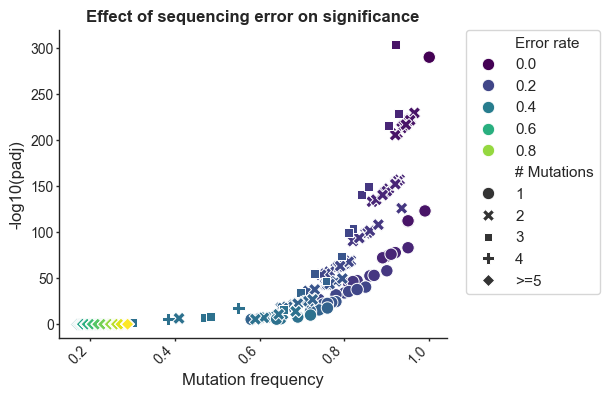

--------------------------------------------------------------------------------
   label	G61T_C62G_C63T	frequency	1.0	combined_p_value	0.0	mixed_well	False	    
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
      label	C62A_C63T	frequency	1.0	combined_p_value	0.0	mixed_well	False	      
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
      label	C62A_C63A	frequency	1.0	combined_p_value	0.0	mixed_well	False	      
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
   label	G61T_C62T_C63T	frequency	1.0	combined_p_value	0.0	mixed_well	False	    
--------------------------------------------------------------------------------
----------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9566666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	C62A_C63T	frequency	0.955	combined_p_value	2.6248404630752837e-223	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62A_C63A	frequency	0.94	combined_p_value	2.0587404319177495e-215	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G61T_C62T_C63T	frequency	0.9566666666666667	combined_p_value	0.0	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62G_C63T	frequency	0.94	combined_p_value	2.698102325770671e-214	mixed_well	False	
--------------------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9133333333333332' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	C62A_C63T	frequency	0.925	combined_p_value	5.775740365766062e-155	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62A_C63A	frequency	0.88	combined_p_value	2.8390437161166508e-139	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G61T_C62T_C63T	frequency	0.9	combined_p_value	5.32746035222376e-215	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62G_C63T	frequency	0.92	combined_p_value	6.572321088709381e-153	mixed_well	False	
------------------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8266666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	C62A_C63T	frequency	0.85	combined_p_value	1.2600600526082985e-98	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62A_C63A	frequency	0.78	combined_p_value	9.277290926299939e-80	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G61T_C62T_C63T	frequency	0.8233333333333333	combined_p_value	2.575442332731785e-135	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62G_C63T	frequency	0.85	combined_p_value	3.804678899752437e-99	mixed_well	False	
------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7866666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	C62A_C63T	frequency	0.795	combined_p_value	2.535957039805514e-65	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62A_C63A	frequency	0.78	combined_p_value	4.438016783092903e-61	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G61T_C62T_C63T	frequency	0.7799999999999999	combined_p_value	3.895843647658045e-91	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62G_C63T	frequency	0.785	combined_p_value	1.7797194505997307e-63	mixed_well	False	
-----------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7533333333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	C62A_C63T	frequency	0.725	combined_p_value	9.667817907558758e-38	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62A_C63A	frequency	0.75	combined_p_value	7.020506109867508e-43	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G61T_C62T_C63T	frequency	0.7566666666666667	combined_p_value	1.7765174143050232e-64	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62G_C63T	frequency	0.75	combined_p_value	6.098163470651479e-43	mixed_well	False	
------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7066666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	C62A_C63T	frequency	0.73	combined_p_value	1.4888528075556525e-29	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62A_C63A	frequency	0.685	combined_p_value	1.339591630872311e-22	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G61T_C62T_C63T	frequency	0.6666666666666666	combined_p_value	1.7090949649261465e-29	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62G_C63T	frequency	0.7	combined_p_value	1.2980148738609972e-24	mixed_well	False	
-----------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5866666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	C62A_C63T_G846T	frequency	0.5	combined_p_value	8.41674795431742e-12	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62A_C63A	frequency	0.675	combined_p_value	2.4450818156473436e-15	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G61T_C62T_C63T_G173T_C660DEL	frequency	0.45200000000000007	combined_p_value	2.7795749536720406e-12	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C62G_C63T_G238DEL	frequency	0.47	combined_p_value	1.915156735608949e-08	mixed_well	False	
--------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2586666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	T53C_C62A_C63T_G64A_T137C_T140C_A150G_G222C_C227T_G256A_G384DEL_G564T_C623A_G699A_A722DEL_T734C_T807A_G811DEL	frequency	0.21777777777777776	combined_p_value	0.9966553622267225	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A38T_C62A_C63A_A101T_G173A_C223T_T315G_G331A_G332DEL_C359T_A491T_C511A_G531DEL_T742C_T781C_A789DEL	frequency	0.228125	combined_p_value	0.9771498980380603	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A1T_G61T_C62T_C63T_A86G_G93T_G120DEL_C172T_T206DEL_C299T_A313DEL_A350G_A470T_G532A_T601DEL_A698DEL_C758G_C760T_C765DEL	frequency	0.23315789473684215	combined_p_value	0.9996403246121025	mixed_well	False	
--------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.17990909090909088' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	G3C_G11A_T12G_G15C_A16T_C18T_C26DEL_A38DEL_G44T_C62A_C63T_G64DEL_A65C_G69C_A70DEL_C73G_T80G_G85A_T95G_T105G_T119G_G120A_C127A_T134G_T137C_T138G_T140C_C174DEL_G177C_T189DEL_T190G_A198G_A209C_G214T_T225DEL_C228A_A230G_G250T_C253G_C275G_C277T_G280A_A284G_C288DEL_G301C_A302C_T312A_G321A_G328A_A330T_T341DEL_A345C_G346T_A349T_G354C_T356C_C359A_G371C_T393A_T403DEL_G411C_C412A_C423DEL_G428C_A431T_G444DEL_C445DEL_C448T_G454T_T464A_A470G_C473A_C479DEL_C486T_A489C_A498DEL_C519T_G522A_G524T_G528T_C530T_C534G_C543A_G546T_G549DEL_A557T_G569T_A571DEL_G573A_G587T_A591T_C592A_T618G_T638DEL_G645DEL_A657T_A667T_T669A_T677DEL_C689T_A693C_C695T_A698T_A731T_G738DEL_T742A_A746T_A779T_G786A_C787T_G794T_G810A_C819T_T835A	frequency	0.17728070175438593	combined_p_value	1.0	mixed_well	False	
--------------------------------------------------------------------------------
---------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.17468911917098448' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	G3T_A4C_G7T_A9G_G11A_C13A_G17C_C18T_C23DEL_C24A_C28DEL_G31A_G32A_G33T_C35G_T37G_A38DEL_T39G_A40T_T41DEL_G44T_C45DEL_A50T_A51G_T53A_T54C_G58C_G61DEL_C62A_C63T_G64A_C67A_C71T_G72DEL_C73A_T79C_A81G_C84G_G85A_T87C_A88G_C91T_A92T_T94G_T96A_C100G_A101T_T105A_T111DEL_C113A_C118A_G120A_C121G_G122C_C123DEL_C124DEL_T126A_G130A_G132C_G133DEL_T134A_T136G_T137A_A141T_C144G_T147DEL_A149T_A150G_G151DEL_A154G_T155A_A157G_C160G_C161A_G162C_C163A_G165T_A170DEL_A171G_C174G_C176A_C178DEL_G181DEL_C182T_C183T_C184A_A185C_G186A_G188T_T189A_G194C_C195A_G196C_A197T_A198DEL_T200G_C202DEL_A203C_A205G_T206G_T207A_A209C_T217G_C219A_C220DEL_T225DEL_G226A_G229DEL_A230DEL_G232C_G233C_T236C_G241C_A242DEL_T245DEL_C246A_C249A_T251G_T254A_G255DEL_A257DEL_C260A_C261G_C267A_A269G_T273A_C275G_T282DEL_G286T_A289G_A290C_G294A_C299G_C300A_A302DEL_G304A_G306A_C308DEL_T312A_A313T_T315DEL_G316C_A318DEL_A319T_G321DEL_C325A_C326DEL_G333A_G334DEL_

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.18190058479532162' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1DEL_T2A_G3T_A4T_G5C_T6A_G7C_A8C_A9DEL_C10G_G11C_T12C_C13DEL_T14A_G15T_A16G_G17C_C18G_A19T_T20A_T21A_A22DEL_C23DEL_C24G_C25A_C28T_T29A_G30T_G32A_G33T_C34G_C35T_G36A_T37DEL_A38T_T39C_A40C_T41C_C42T_G43A_C45A_G46C_C47DEL_C49A_A50DEL_A51C_T53DEL_T54G_T55C_C56DEL_G57A_G58A_T60A_G61A_C62A_C63T_G64T_C66DEL_C67DEL_T68A_A70DEL_G72DEL_C73G_G74DEL_C75DEL_C76T_C77T_G78C_T80G_A81C_A82T_G83A_C84T_G85C_A86T_T87G_A89T_T90DEL_C91G_A92T_G93DEL_T94A_T95A_T96G_G97A_A98T_C100T_G102T_T104C_T105C_A107G_C108T_C109DEL_A110C_T111DEL_G112T_G114DEL_G115C_T116G_C118G_T119G_G120C_C121DEL_G122DEL_C124DEL_A125G_T126DEL_A128DEL_G129T_G130T_T131C_G132T_G133A_T134A_G135C_T136G_T137C_T138C_C139A_T140C_A141G_C142G_G143A_C144DEL_C148T_A149G_A150G_C152DEL_T153A_A154T_T155A_A157G_C158A_G159A_C160T_C161T_G162A_C163A_G165T_C166A_A167DEL_G168A_C169A_A171T_C172DEL_G173A_C174A_G175T_C176T_C178G_G180DEL_G181T_C182T_C183A_C184A_A185T_G186A_C187

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19278648974668275' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1G_T2C_G3C_A4G_G5T_T6DEL_G7T_A8G_A9T_C10G_G11T_C13G_T14C_G15A_A16T_G17A_C18T_A19T_T20DEL_T21A_A22C_C23T_C24G_C25T_C26T_G27A_C28DEL_T29DEL_G30T_G31C_G32DEL_G33C_C34A_G36T_T37A_A38DEL_T39G_A40DEL_T41A_C42G_G44T_C45A_G46T_C47A_A48C_C49DEL_A50G_A51C_A52G_T53C_T54A_T55DEL_C56T_G57A_G58T_G59A_T60A_G61DEL_C62A_C63T_G64A_A65C_C66T_C67T_T68G_G69T_A70DEL_C71A_G72A_C73G_G74C_C75T_C76A_C77A_G78A_T80A_A81G_A82DEL_G83C_C84G_G85C_A86DEL_T87DEL_A88C_A89C_T90C_C91DEL_A92G_G93A_T94DEL_T95G_T96C_G97A_A98C_A99DEL_C100DEL_A101DEL_G102A_C103DEL_T104DEL_T105G_T106A_A107C_C108T_C109T_A110G_T111G_G112A_C113G_G114DEL_G115T_T116C_G117T_C118A_T119DEL_G120DEL_C121A_G122DEL_C123T_A125C_T126DEL_C127A_A128DEL_G129T_G130T_T131C_G132A_G133C_T134C_G135DEL_T136A_T137A_T138DEL_C139G_T140DEL_A141C_C142T_C144T_G145A_A146T_T147A_C148DEL_A149G_A150T_G151A_C152T_T153DEL_A154T_T155A_T156G_A157G_G159C_C160A_C161G_G162T_C163T_A164C_G165C_A167G

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.20343896713615023' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1G_T2C_G3T_A4C_G5T_T6G_G7A_A8T_A9C_C10T_G11DEL_T12G_C13G_T14G_G15T_A16G_G17C_C18DEL_A19T_T20G_T21G_A22DEL_C23A_C24G_C25G_C26G_G27C_C28T_T29A_G30C_G31A_G32C_G33C_C34T_C35DEL_G36DEL_T37DEL_A38C_T39C_A40DEL_T41C_C42A_G43A_G44C_C45DEL_G46A_C47A_A48C_C49G_A50T_A51C_A52T_T53DEL_T54DEL_T55C_C56DEL_G57DEL_G58DEL_G59DEL_T60DEL_G61DEL_C62A_C63T_G64C_A65G_C66DEL_C67A_T68DEL_G69A_A70C_C71G_G72T_C73T_G74A_C75DEL_C76A_C77T_G78T_T79C_T80G_A81C_A82C_G83DEL_C84G_G85A_A86DEL_T87C_A88DEL_A89G_T90A_C91T_A92G_G93A_T94C_T95A_T96DEL_G97T_A98T_A99T_C100G_A101C_G102DEL_C103G_T104A_T105A_T106A_A107T_C108T_C109G_A110G_T111C_G112T_C113DEL_G114C_G115T_T116A_G117T_C118T_T119C_G120A_C121T_G122T_C123G_C124DEL_A125C_T126C_C127DEL_A128T_G129DEL_G130A_T131A_G132T_G133A_T134G_G135DEL_T136G_T137C_T138G_C139DEL_T140A_A141G_C142T_G143T_C144A_G145DEL_A146C_T147DEL_C148G_A149T_A150DEL_G151A_C152A_T153DEL_A154T_T155A_T156G_A157G_C158DEL_G15

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.22046948356807516' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1T_T2G_G3T_A4T_G5DEL_T6G_G7A_A8T_A9DEL_C10DEL_G11A_T12A_C13G_T14C_G15A_A16C_G17C_C18G_A19T_T20C_T21A_A22DEL_C23DEL_C24DEL_C25T_C26DEL_G27T_C28A_T29C_G30C_G31A_G32DEL_G33A_C34T_C35G_G36C_T37G_A38C_T39A_A40DEL_T41C_C42T_G43A_G44C_C45T_G46T_C47A_A48T_C49T_A50C_A51C_A52T_T53G_T54G_T55DEL_C56G_G57A_G58T_G59C_T60G_G61C_C62A_C63T_G64T_A65C_C66T_C67G_T68A_G69DEL_A70G_C71T_G72A_C73DEL_G74T_C75G_C76DEL_C77A_G78C_T79DEL_T80C_A81G_A82T_G83C_C84G_G85C_A86G_T87A_A88C_A89DEL_T90A_C91DEL_A92G_G93DEL_T94A_T95A_T96DEL_G97C_A98DEL_A99G_C100A_A101T_G102A_C103T_T104G_T105G_T106C_A107T_C108A_C109A_A110G_T111G_G112C_C113A_G114DEL_G115A_T116DEL_G117DEL_C118A_T119C_G120DEL_C121G_G122DEL_C123T_C124DEL_A125G_T126DEL_C127DEL_A128G_G129C_G130A_T131A_G132DEL_G133C_T134A_G135C_T136DEL_T137C_T138G_C139T_T140A_A141DEL_C142DEL_G143C_C144A_G145C_A146T_T147G_C148A_A149C_A150DEL_G151T_C152DEL_T153G_A154T_T155C_T156A_A157C_C158T_G159DEL

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2325117370892019' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1C_T2G_G3C_A4T_G5DEL_T6A_G7C_A8T_A9C_C10T_G11T_T12DEL_C13A_T14G_G15T_A16C_G17DEL_C18A_A19G_T20DEL_T21C_A22C_C23DEL_C24T_C25DEL_C26A_G27C_C28G_T29A_G30C_G31T_G32C_G33T_C34T_C35G_G36C_T37G_A38G_T39G_A40C_T41C_C42G_G43DEL_G44C_C45DEL_G46T_C47A_A48C_C49DEL_A50T_A51DEL_A52DEL_T53DEL_T54C_T55DEL_C56DEL_G57T_G58DEL_G59DEL_T60A_G61A_C62A_C63DEL_G64A_A65DEL_C66DEL_C67DEL_T68A_G69A_A70DEL_C71A_G72A_C73T_G74C_C75A_C76A_C77T_G78DEL_T79G_T80G_A81T_A82DEL_G83T_C84T_G85A_A86C_T87A_A88G_A89T_T90DEL_C91A_A92T_G93T_T94DEL_T95C_T96G_G97C_A98T_A99T_C100G_A101T_G102A_C103A_T104C_T105C_T106C_A107G_C108DEL_C109DEL_A110G_T111DEL_G112T_C113G_G114A_G115C_T116A_G117A_C118A_T119C_G120T_C121G_G122A_C123T_C124G_A125G_T126G_C127DEL_A128T_G129T_G130T_T131DEL_G132C_G133T_T134C_G135DEL_T136G_T137A_T138G_C139G_T140A_A141C_C142G_G143A_C144T_G145A_A146T_T147A_C148G_A149T_A150G_G151T_C152G_T153G_A154C_T155DEL_T156C_A157DEL_C158G_G159C_C

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24747652582159624' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1T_T2A_G3A_A4T_G5A_T6G_G7T_A8C_A9G_C10DEL_G11T_T12G_C13T_T14G_G15A_A16C_G17DEL_C18DEL_A19G_T20DEL_T21A_A22G_C23DEL_C24A_C25DEL_C26DEL_G27C_C28A_T29G_G30DEL_G31T_G32DEL_G33A_C34DEL_C35G_G36A_T37A_A38DEL_T39G_A40DEL_T41G_C42A_G43A_G44A_C45DEL_G46T_C47DEL_A48C_C49A_A50C_A51G_A52T_T53A_T54C_T55G_C56DEL_G57T_G58C_G59DEL_T60A_G61DEL_C62T_C63T_G64A_A65DEL_C66A_C67T_T68G_G69A_A70T_C71A_G72DEL_C73T_G74A_C75A_C76T_C77DEL_G78DEL_T79G_T80DEL_A81G_A82DEL_G83C_C84T_G85DEL_A86G_T87DEL_A88G_A89DEL_T90G_C91A_A92DEL_G93C_T94A_T95A_T96G_G97C_A98DEL_A99T_C100A_A101G_G102T_C103DEL_T104G_T105C_T106C_A107T_C108T_C109G_A110T_T111G_G112C_C113DEL_G114C_G115DEL_T116A_G117C_C118A_T119C_G120T_C121DEL_G122T_C123A_C124A_A125T_T126G_C127DEL_A128G_G129C_G130C_T131DEL_G132C_G133T_T134DEL_G135A_T136A_T137G_T138DEL_C139G_T140G_A141G_C142T_G143DEL_C144A_G145A_A146C_T147DEL_C148T_A149C_A150DEL_G151DEL_C152A_T153A_A154G_T155DEL_T156C_A15

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2603169014084507' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1C_T2A_G3C_A4C_G5A_T6G_G7T_A8T_A9G_C10G_G11T_T12A_C13G_T14C_G15A_A16DEL_G17C_C18T_A19T_T20C_T21A_A22G_C23T_C24DEL_C25A_C26G_G27T_C28G_T29C_G30C_G31A_G32DEL_G33DEL_C34A_C35A_G36A_T37G_A38T_T39DEL_A40C_T41G_C42DEL_G43C_G44A_C45DEL_G46DEL_C47DEL_A48T_C49T_A50T_A51C_A52C_T53C_T54G_T55C_C56DEL_G57A_G58A_G59A_T60A_G61A_C62DEL_C63T_G64DEL_A65T_C66G_C67A_T68C_G69C_A70G_C71T_G72DEL_C73T_G74A_C75A_C76T_C77T_G78C_T79G_T80A_A81G_A82DEL_G83C_C84T_G85A_A86T_T87A_A88DEL_A89G_T90A_C91A_A92G_G93A_T94DEL_T95A_T96G_G97DEL_A98G_A99C_C100T_A101C_G102C_C103G_T104C_T105G_T106DEL_A107DEL_C108A_C109T_A110T_T111A_G112T_C113A_G114C_G115DEL_T116DEL_G117T_C118DEL_T119DEL_G120A_C121A_G122DEL_C123DEL_C124DEL_A125G_T126A_C127T_A128DEL_G129DEL_G130DEL_T131C_G132T_G133A_T134DEL_G135DEL_T136DEL_T137DEL_T138DEL_C139A_T140DEL_A141T_C142DEL_G143DEL_C144G_G145DEL_A146T_T147A_C148G_A149DEL_A150T_G151DEL_C152G_T153C_A154G_T155A_T156A_A157D

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2750469483568075' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1C_T2C_G3DEL_A4T_G5C_T6A_G7T_A8G_A9G_C10DEL_G11A_T12DEL_C13A_T14A_G15DEL_A16DEL_G17A_C18T_A19T_T20DEL_T21C_A22C_C23G_C24T_C25A_C26G_G27DEL_C28G_T29A_G30A_G31DEL_G32A_G33DEL_C34DEL_C35T_G36T_T37G_A38G_T39DEL_A40C_T41A_C42G_G43A_G44A_C45DEL_G46C_C47DEL_A48C_C49DEL_A50T_A51T_A52G_T53A_T54G_T55C_C56A_G57A_G58C_G59DEL_T60C_G61DEL_C62G_C63G_G64A_A65G_C66G_C67A_T68DEL_G69C_A70G_C71T_G72C_C73A_G74C_C75DEL_C76T_C77DEL_G78C_T79C_T80DEL_A81C_A82G_G83A_C84A_G85A_A86C_T87C_A88G_A89C_T90C_C91DEL_A92C_G93DEL_T94C_T95A_T96A_G97A_A98DEL_A99G_C100G_A101T_G102C_C103G_T104C_T105A_T106C_A107C_C108G_C109T_A110DEL_T111C_G112A_C113G_G114T_G115A_T116C_G117T_C118G_T119C_G120C_C121DEL_G122A_C123G_C124G_A125DEL_T126DEL_C127T_A128C_G129T_G130DEL_T131G_G132T_G133T_T134DEL_G135A_T136DEL_T137G_T138DEL_C139DEL_T140G_A141C_C142T_G143C_C144G_G145DEL_A146T_T147C_C148G_A149T_A150T_G151DEL_C152T_T153C_A154G_T155C_T156G_A157T_C158A_G159T

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.288462441314554' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1G_T2G_G3T_A4DEL_G5C_T6G_G7A_A8G_A9G_C10DEL_G11C_T12DEL_C13G_T14A_G15C_A16G_G17C_C18G_A19DEL_T20G_T21C_A22T_C23T_C24T_C25T_C26A_G27DEL_C28G_T29A_G30T_G31A_G32DEL_G33A_C34DEL_C35T_G36T_T37DEL_A38DEL_T39C_A40T_T41DEL_C42A_G43C_G44C_C45DEL_G46DEL_C47T_A48C_C49T_A50C_A51T_A52T_T53A_T54C_T55C_C56G_G57T_G58T_G59A_T60C_G61A_C62G_C63G_G64T_A65C_C66A_C67G_T68G_G69T_A70DEL_C71DEL_G72DEL_C73G_G74C_C75G_C76T_C77DEL_G78C_T79C_T80C_A81C_A82C_G83C_C84A_G85A_A86T_T87A_A88G_A89C_T90C_C91T_A92G_G93DEL_T94C_T95G_T96A_G97T_A98DEL_A99C_C100DEL_A101T_G102A_C103A_T104C_T105G_T106DEL_A107DEL_C108G_C109T_A110C_T111C_G112A_C113G_G114C_G115A_T116A_G117T_C118A_T119DEL_G120C_C121G_G122A_C123DEL_C124G_A125DEL_T126DEL_C127T_A128C_G129A_G130A_T131G_G132C_G133A_T134G_G135A_T136A_T137A_T138A_C139DEL_T140G_A141G_C142A_G143DEL_C144DEL_G145C_A146C_T147G_C148A_A149T_A150G_G151C_C152A_T153DEL_A154T_T155DEL_T156C_A157G_C158DEL_G159A_C160A

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/1568760798.py:16: RuntimeWarning: divide by zero encountered in log10
  experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/1645634591.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


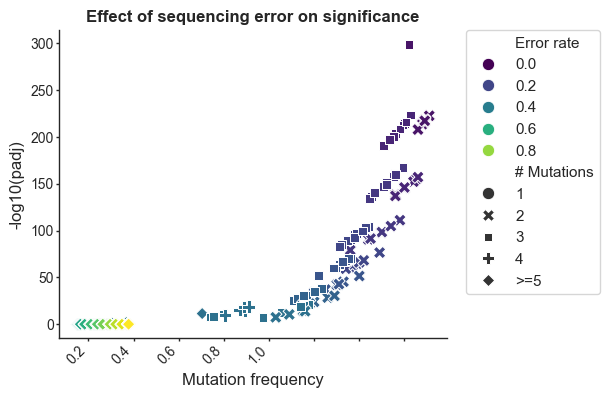

--------------------------------------------------------------------------------
label	A302C	frequency	1.0	combined_p_value	7.699811939847464e-291	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     label	G301T_A302G	frequency	1.0	combined_p_value	0.0	mixed_well	False	     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	T303A	frequency	1.0	combined_p_value	7.699811939847464e-291	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
     label	G301T_A302T	frequency	1.0	combined_p_value	0.0	mixed_well	False	     
--------------------------------------------------------------------------------
----------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.95' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	G301T_A302G	frequency	0.96	combined_p_value	1.0530802103602402e-224	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	T303A	frequency	0.95	combined_p_value	1.5007809387816677e-113	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G301T_A302T	frequency	0.9450000000000001	combined_p_value	9.33137191334229e-217	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A302G	frequency	0.96	combined_p_value	8.313421945516616e-115	mixed_well	False	
------------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.93' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	G301T_A302G	frequency	0.895	combined_p_value	6.364030521789109e-143	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	T303A	frequency	0.87	combined_p_value	1.2571349792885183e-68	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G301T_A302T	frequency	0.93	combined_p_value	4.6577326830139825e-157	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A302G	frequency	0.91	combined_p_value	3.817332544373711e-77	mixed_well	False	
--------------------------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.83' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	G301T_A302G	frequency	0.86	combined_p_value	5.66363861462949e-102	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	T303A	frequency	0.87	combined_p_value	1.31322670825402e-54	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G301T_A302T	frequency	0.865	combined_p_value	2.1432853133775255e-104	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A302G	frequency	0.87	combined_p_value	1.1420501654946536e-54	mixed_well	False	
--------------------------------------------------------------------------------
-

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.77' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	G301T_A302G	frequency	0.76	combined_p_value	6.785531400715124e-58	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	T303A	frequency	0.84	combined_p_value	1.3458457528073677e-39	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G301T_A302T	frequency	0.8049999999999999	combined_p_value	1.7367665126195727e-67	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A302G	frequency	0.84	combined_p_value	1.0414665032424227e-39	mixed_well	False	
--------------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.67' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	G301T_A302G	frequency	0.735	combined_p_value	8.18517208956634e-40	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	T303A	frequency	0.68	combined_p_value	1.3544255385508754e-16	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G301T_A302T	frequency	0.725	combined_p_value	3.531181336515692e-38	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A302G	frequency	0.8	combined_p_value	1.3268531973197842e-27	mixed_well	False	
--------------------------------------------------------------------------------
--

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.71' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	G301T_A302G	frequency	0.6499999999999999	combined_p_value	1.431213721080778e-18	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	T303A	frequency	0.78	combined_p_value	6.570261483249097e-20	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G301T_A302T	frequency	0.6950000000000001	combined_p_value	3.7274835699398276e-24	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A302G	frequency	0.65	combined_p_value	5.908805921785909e-10	mixed_well	False	
--------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	G301T_A302G_A324C	frequency	0.49	combined_p_value	2.5647961536807084e-11	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A198T_T303A_G507A	frequency	0.29000000000000004	combined_p_value	0.695584365972157	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G301T_A302T	frequency	0.64	combined_p_value	8.724863809198897e-11	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	A302G_G481T_A852DEL	frequency	0.31	combined_p_value	0.04558674844841894	mixed_well	False	
-------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2009090909090909' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	C56G_T116A_G256C_A283C_C299G_G301T_A302G_C326T_A351T_G406C_C430T_G481A_G505T_C654A_T684A_C721A_C812A	frequency	0.23000000000000004	combined_p_value	0.5167763865256108	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	G36A_G85A_C123G_G222A_G256C_T303A_T420G_C426T_T463C_G537A_C559DEL_G573C_C737A_C796A	frequency	0.20428571428571432	combined_p_value	0.9349948045265518	mixed_well	False	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
label	C108DEL_C113G_T131A_T153C_C172A_G301T_A302T_A324C_G354A_G370DEL_C387A_T403DEL_T437C_A540C_T588G_T707DEL_C717T_A746C	frequency	0.21666666666666667	combined_p_value	0.9346222137943173	mixed_well	False	
------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.17570175438596491' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1T_A4C_T6G_A8T_C10A_G11T_T21A_C24T_C35A_A40DEL_C76G_G83T_T87C_T105A_A150G_A157DEL_C161A_G162A_A164T_A167C_G180T_A185C_T191G_G201A_C208A_G214A_T217C_T225C_G226T_A230G_T237DEL_C240T_A247T_G252T_C262G_A272G_C275G_A283G_C291A_C295T_G301T_A302G_A313C_A317C_G342C_A349T_T356G_C366T_G368T_G373T_C379DEL_T382DEL_T393A_T403C_G411C_C422DEL_C427DEL_G435T_T437A_G442DEL_G453C_G460A_T468DEL_G480A_T490C_A515G_C517T_T520DEL_G546T_A555G_C559T_C560T_C574A_A593G_G606T_A607G_T629G_G631T_G641A_G649C_C659A_A666G_T672C_T673A_T674A_T678C_C681A_A692G_C695A_G697C_A698C_T700C_A704C_T707A_C709DEL_C715T_A723G_G730A_G744A_A761C_A764T_T774C_A779C_A782DEL_C783A_C784G_A791T_G798A_A799C_T803C_T822DEL_G824C_G826T_A831G_T840G	frequency	0.1804347826086957	combined_p_value	1.0	mixed_well	False	
--------------------------------------------------------------------------------
-----------------------------------------------------------------

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.17538461538461533' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1G_T2A_G3C_A4G_G5T_T6A_A8T_A9G_C13T_T14C_G15T_C24T_C26G_G27C_G30A_G31A_G33DEL_C35DEL_T37C_C42A_C45G_G46DEL_A48T_C49G_T55A_C56A_G58C_G59DEL_T60G_C63DEL_C67T_T68A_A70C_C73G_G74C_C75DEL_C76T_T79A_A81C_A82G_A86T_A89C_T90A_C91DEL_A92G_G93T_T95A_T96C_A99DEL_C100DEL_A101T_T104G_T105G_T106G_C109DEL_T111C_G112A_G114C_T116G_G117DEL_G120T_C121T_C124G_G130C_T134A_G135DEL_T136A_T137G_T138G_A146C_T147A_A150T_C152T_T153A_T155A_A157DEL_C161DEL_C163G_A164DEL_C169DEL_A171T_C172T_G173T_G175C_C176T_G177DEL_C178A_C182G_C184G_A185T_C187A_G188A_G193DEL_A198C_T200C_A203G_A205C_T207G_C208T_C210DEL_C212T_T213G_G214T_T215C_A218T_C219G_C221A_T225C_A230G_A231C_G234A_G235A_T236G_G238T_A239G_G243T_A244DEL_C246A_T248A_C249G_G250DEL_T251G_G252DEL_C253DEL_T254G_T258A_A259T_C260G_C261A_T270DEL_A271C_T273DEL_C274A_C277DEL_A279G_G280C_A290C_C299G_G301T_A302G_G304A_T305G_G306C_A307G_T310C_T311C_T312G_T314A_A317C_A318C_G321C_C323DEL_A324

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.18166666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	T2DEL_G3A_A4DEL_G5T_T6DEL_G7C_A8G_C10A_G11DEL_T12G_C13T_T14A_G15DEL_A16G_G17A_C18G_T20G_T21G_C23DEL_C24T_C25A_C26A_G27C_C28A_T29A_G31A_G32A_G33DEL_C34T_C35T_G36A_T37DEL_A38C_T39G_A40G_G43A_G44DEL_G46A_C47T_A48G_C49A_A50T_A51G_T53DEL_T54A_T55G_C56G_G57A_G59C_T60C_G61C_G64A_A65C_C67DEL_G69C_A70C_C71A_G72C_C73A_G74C_C75DEL_C76G_C77A_G78C_T79A_A81DEL_A82T_G83A_C84G_G85A_A86T_T87C_A88DEL_A89DEL_T90A_C91T_A92G_T94DEL_T95A_T96DEL_G97DEL_A98T_A99C_C100DEL_A101G_G102T_C103A_T104DEL_T105A_T106A_A107C_C108G_A110G_T111DEL_G112DEL_C113DEL_G114C_G115T_T116A_G117A_C118DEL_T119A_G120A_C121DEL_C123T_C124G_A125G_C127G_A128C_G130C_T131C_G132A_T134G_G135T_T137G_T138G_C139DEL_T140C_A141DEL_G143C_C144A_G145C_A146T_C148A_A149T_C152G_T153G_A154G_T155C_T156G_A157T_C158A_G159A_C160T_G162C_A164C_G165A_A167T_G168C_C169DEL_A170T_C172T_C174DEL_G175DEL_C176G_C178T_T179A_G180DEL_G181A_C182DEL_C183A_C184A_A185DEL_G186T_C187A_G188T_T

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1917208182912154' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1C_T2DEL_G3A_A4G_G5A_T6A_G7A_A8G_A9DEL_C10T_G11T_T12A_C13A_T14DEL_G15T_A16DEL_G17DEL_C18G_A19DEL_T20A_T21A_A22T_C23A_C24DEL_C25DEL_C26T_G27T_C28DEL_T29A_G30DEL_G31A_G32C_G33C_C34A_C35A_G36DEL_T37DEL_A38T_T39DEL_A40G_T41A_C42DEL_G43C_G44DEL_C45G_G46DEL_C47DEL_A48T_C49A_A50T_A51G_A52T_T53DEL_T54A_T55A_C56T_G57T_G58A_G59T_T60G_G61T_C62T_C63T_G64DEL_C66T_C67DEL_T68A_G69T_A70DEL_C71DEL_G72DEL_C73A_G74C_C76DEL_C77T_G78A_T79A_T80G_A81T_A82T_G83DEL_C84A_G85C_A86T_T87G_A88G_A89C_T90G_C91A_A92C_G93DEL_T94A_T95DEL_T96A_G97T_A98G_A99G_C100DEL_A101C_G102C_C103G_T104A_T105C_T106A_C108T_C109G_A110T_T111A_G112DEL_C113T_G114A_G115C_T116DEL_G117C_C118T_T119G_G120DEL_C121G_G122C_C123A_C124G_A125DEL_T126A_C127A_A128G_G129A_G130T_T131G_G132DEL_G133A_T134G_G135A_T136A_T137C_T138C_C139A_T140C_A141G_C142A_G143C_C144T_G145C_A146C_T147G_C148A_A149C_A150DEL_G151T_C152G_T153DEL_A154C_T155G_T156DEL_A157T_C158A_G159T_C160DEL_C16

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2050352941176471' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1C_T2C_G3A_A4DEL_G5A_T6C_G7DEL_A8C_A9C_C10A_G11T_T12C_C13T_T14C_G15DEL_A16T_G17T_C18A_A19C_T20G_T21G_A22DEL_C23A_C24T_C25T_C26T_G27C_C28DEL_T29C_G30A_G31A_G32DEL_G33DEL_C34T_C35G_G36A_T37C_A38T_T39A_A40G_T41G_C42G_G43DEL_G44A_C45G_G46DEL_C47G_A48C_C49T_A50G_A51G_A52T_T53A_T54C_T55G_C56T_G57T_G58A_G59T_T60G_G61T_C62G_C63G_G64DEL_A65C_C66G_C67T_T68A_G69A_A70T_C71G_G72T_C73DEL_G74C_C75A_C76A_C77T_G78DEL_T79DEL_T80A_A81T_A82C_G83C_C84A_G85DEL_A86T_T87A_A88T_A89T_T90A_C91T_A92DEL_G93DEL_T94A_T95A_T96G_G97C_A98T_A99C_C100G_A101DEL_G102A_C103DEL_T104C_T105A_T106A_A107DEL_C108G_C109DEL_A110C_T111G_G112T_C113DEL_G114T_G115T_T116G_G117C_C118T_T119A_G120A_C121G_G122A_C123DEL_C124T_A125T_T126A_C127G_A128T_G129T_G130T_T131C_G132C_G133T_T134A_G135A_T136A_T137A_T138A_C139T_T140C_A141DEL_C142DEL_G143T_C144T_G145T_A146DEL_T147C_C148T_A149C_A150G_G151DEL_C152T_T153A_A154G_T155DEL_T156DEL_A157DEL_C158T_G159C_C160G_C16

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2191549295774648' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1DEL_T2G_G3DEL_A4T_G5DEL_T6A_G7A_A8DEL_A9T_C10T_G11T_T12A_C13A_T14C_G15A_A16C_G17DEL_C18DEL_A19C_T20G_T21G_A22C_C23T_C24G_C25A_C26A_G27DEL_C28G_T29C_G30A_G31DEL_G32C_G33A_C34A_C35G_G36T_T37G_A38G_T39G_A40DEL_T41C_C42G_G43T_G44C_C45A_G46C_C47DEL_A48T_C49A_A50T_A51C_A52C_T53DEL_T54C_T55G_C56T_G57DEL_G58C_G59T_T60C_G61A_C62A_C63A_G64A_A65T_C66A_C67DEL_T68A_G69T_A70T_C71G_G72C_C73G_G74A_C75T_C76A_C77T_G78DEL_T79A_T80A_A81C_A82G_G83A_C84T_G85DEL_A86G_T87C_A88C_A89C_T90DEL_C91G_A92G_G93T_T94A_T95DEL_T96DEL_G97DEL_A98DEL_A99G_C100T_A101G_G102T_C103G_T104C_T105A_T106DEL_A107T_C108T_C109G_A110G_T111C_G112A_C113T_G114A_G115T_T116A_G117T_C118A_T119A_G120DEL_C121G_G122C_C123A_C124G_A125DEL_T126C_C127A_A128T_G129T_G130A_T131DEL_G132A_G133T_T134A_G135C_T136A_T137DEL_T138C_C139T_T140A_A141G_C142T_G143C_C144G_G145C_A146C_T147C_C148A_A149DEL_A150T_G151A_C152A_T153G_A154C_T155G_T156A_A157G_C158G_G159DEL_C160G_C161G_G

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.23268779342723006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1T_T2C_G3T_A4DEL_G5A_T6A_G7DEL_A8DEL_A9T_C10A_G11T_T12A_C13T_T14DEL_G15A_A16T_G17T_C18DEL_A19T_T20A_T21C_A22DEL_C23A_C24G_C25DEL_C26T_G27C_C28G_T29C_G30DEL_G31C_G32T_G33T_C34T_C35G_G36DEL_T37C_A38G_T39G_A40C_T41C_C42T_G43C_G44A_C45DEL_G46A_C47G_A48T_C49T_A50DEL_A51C_A52C_T53C_T54G_T55G_C56A_G57T_G58C_G59C_T60C_G61C_C62T_C63T_G64DEL_A65T_C66DEL_C67T_T68C_G69A_A70G_C71G_G72A_C73A_G74DEL_C75T_C76A_C77G_G78C_T79C_T80C_A81DEL_A82C_G83T_C84T_G85C_A86G_T87DEL_A88C_A89G_T90G_C91A_A92DEL_G93C_T94C_T95A_T96G_G97DEL_A98G_A99G_C100G_A101G_G102A_C103DEL_T104DEL_T105DEL_T106G_A107G_C108T_C109DEL_A110T_T111G_G112T_C113G_G114C_G115DEL_T116C_G117A_C118DEL_T119DEL_G120T_C121A_G122T_C123A_C124A_A125C_T126C_C127DEL_A128G_G129T_G130T_T131DEL_G132C_G133C_T134G_G135C_T136A_T137DEL_T138G_C139A_T140A_A141C_C142DEL_G143C_C144A_G145T_A146T_T147A_C148DEL_A149G_A150C_G151T_C152DEL_T153A_A154DEL_T155A_T156C_A157C_C158G_G159A_C16

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24827464788732395' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1G_T2A_G3A_A4C_G5C_T6DEL_G7C_A8G_A9T_C10T_G11T_T12C_C13T_T14DEL_G15A_A16G_G17DEL_C18G_A19DEL_T20DEL_T21DEL_A22T_C23T_C24DEL_C25DEL_C26A_G27DEL_C28T_T29DEL_G30A_G31T_G32T_G33DEL_C34DEL_C35G_G36DEL_T37DEL_A38G_T39G_A40C_T41DEL_C42T_G43C_G44DEL_C45G_G46A_C47T_A48DEL_C49G_A50C_A51T_A52T_T53A_T54DEL_T55A_C56DEL_G57DEL_G58A_G59DEL_T60C_G61T_C62T_C63G_G64C_A65DEL_C66DEL_C67DEL_T68G_G69T_A70C_C71DEL_G72DEL_C73T_G74A_C75DEL_C76G_C77A_G78DEL_T79C_T80DEL_A81T_A82C_G83C_C84A_G85C_A86DEL_T87A_A88G_A89G_T90C_C91DEL_A92C_G93A_T94C_T95G_T96C_G97DEL_A98G_A99C_C100A_A101C_G102T_C103G_T104C_T105A_T106DEL_A107T_C108DEL_C109A_A110G_T111A_G112DEL_C113T_G114A_G115A_T116DEL_G117T_C118G_T119G_G120A_C121T_G122A_C123G_C124A_A125T_T126DEL_C127DEL_A128DEL_G129T_G130T_T131A_G132DEL_G133A_T134G_G135C_T136G_T137G_T138A_C139T_T140C_A141DEL_C142G_G143T_C144A_G145A_A146C_T147DEL_C148G_A149G_A150T_G151DEL_C152DEL_T153G_A154T_T155DEL_T

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.26089201877934276' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1DEL_T2C_G3DEL_A4T_G5A_T6C_G7T_A8DEL_A9G_C10G_G11C_T12G_C13A_T14A_G15T_A16C_G17DEL_C18A_A19DEL_T20C_T21C_A22DEL_C23A_C24A_C25DEL_C26DEL_G27A_C28A_T29G_G30T_G31C_G32A_G33T_C34G_C35G_G36T_T37A_A38C_T39G_A40C_T41A_C42DEL_G43A_G44T_C45G_G46C_C47T_A48G_C49DEL_A50C_A51DEL_A52T_T53DEL_T54G_T55G_C56T_G57DEL_G58A_G59A_T60C_G61C_C62G_C63G_G64C_A65C_C66G_C67A_T68C_G69A_A70G_C71G_G72A_C73T_G74DEL_C75T_C76G_C77G_G78C_T79C_T80A_A81DEL_A82T_G83C_C84G_G85T_A86T_T87A_A88C_A89T_T90G_C91DEL_A92C_G93T_T94DEL_T95A_T96G_G97DEL_A98T_A99C_C100A_A101DEL_G102C_C103T_T104A_T105DEL_T106DEL_A107T_C108DEL_C109T_A110T_T111G_G112C_C113G_G114DEL_G115A_T116DEL_G117C_C118DEL_T119G_G120T_C121G_G122DEL_C123DEL_C124A_A125T_T126G_C127T_A128G_G129DEL_G130A_T131G_G132DEL_G133A_T134DEL_G135A_T136A_T137A_T138A_C139T_T140C_A141T_C142A_G143C_C144T_G145A_A146T_T147C_C148G_A149T_A150C_G151DEL_C152DEL_T153A_A154T_T155DEL_T156DEL_A157C_C158DEL_G15

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2732042253521127' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1C_T2DEL_G3DEL_A4G_G5A_T6DEL_G7A_A8DEL_A9C_C10DEL_G11C_T12C_C13G_T14G_G15DEL_A16C_G17T_C18G_A19G_T20C_T21A_A22C_C23T_C24A_C25T_C26G_G27DEL_C28T_T29C_G30T_G31C_G32DEL_G33C_C34G_C35G_G36C_T37C_A38DEL_T39C_A40T_T41C_C42A_G43C_G44T_C45G_G46C_C47T_A48T_C49DEL_A50G_A51C_A52T_T53DEL_T54C_T55DEL_C56DEL_G57DEL_G58T_G59A_T60A_G61A_C62A_C63A_G64A_A65C_C66T_C67A_T68G_G69A_A70DEL_C71DEL_G72C_C73G_G74T_C75T_C76G_C77T_G78T_T79DEL_T80DEL_A81C_A82T_G83T_C84A_G85DEL_A86C_T87C_A88C_A89C_T90G_C91G_A92T_G93T_T94G_T95A_T96G_G97A_A98T_A99T_C100A_A101DEL_G102DEL_C103A_T104C_T105C_T106DEL_A107G_C108DEL_C109DEL_A110T_T111G_G112DEL_C113A_G114DEL_G115A_T116A_G117T_C118A_T119G_G120T_C121A_G122C_C123G_C124A_A125G_T126C_C127G_A128DEL_G129T_G130C_T131G_G132DEL_G133C_T134C_G135T_T136G_T137G_T138DEL_C139A_T140DEL_A141DEL_C142T_G143C_C144A_G145T_A146C_T147A_C148DEL_A149C_A150C_G151T_C152DEL_T153DEL_A154C_T155A_T156G_A157C_C158DEL_G15

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/4096334951.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.28949530516431926' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
label	A1DEL_T2G_G3DEL_A4T_G5DEL_T6DEL_G7C_A8G_A9DEL_C10A_G11C_T12A_C13A_T14DEL_G15C_A16C_G17A_C18G_A19C_T20DEL_T21C_A22C_C23T_C24A_C25G_C26G_G27T_C28DEL_T29A_G30C_G31A_G32DEL_G33A_C34T_C35G_G36C_T37G_A38T_T39A_A40G_T41A_C42A_G43T_G44T_C45G_G46A_C47T_A48DEL_C49T_A50DEL_A51C_A52G_T53G_T54C_T55C_C56T_G57C_G58C_G59T_T60G_G61T_C62G_C63G_G64A_A65DEL_C66T_C67A_T68DEL_G69T_A70C_C71G_G72A_C73G_G74DEL_C75DEL_C76A_C77T_G78A_T79G_T80G_A81T_A82C_G83A_C84A_G85T_A86T_T87G_A88T_A89C_T90A_C91A_A92C_G93A_T94C_T95DEL_T96DEL_G97DEL_A98T_A99DEL_C100G_A101T_G102DEL_C103T_T104DEL_T105A_T106A_A107T_C108A_C109T_A110T_T111G_G112C_C113G_G114T_G115C_T116DEL_G117A_C118A_T119C_G120A_C121T_G122T_C123A_C124A_A125C_T126G_C127DEL_A128C_G129C_G130C_T131C_G132T_G133A_T134A_G135A_T136DEL_T137C_T138DEL_C139G_T140C_A141C_C142DEL_G143A_C144A_G145DEL_A146G_T147G_C148DEL_A149DEL_A150C_G151T_C152A_T153A_A154G_T155DEL_T156G_A157G_C158A_G159C_C160A_C

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/1568760798.py:16: RuntimeWarning: divide by zero encountered in log10
  experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/1645634591.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


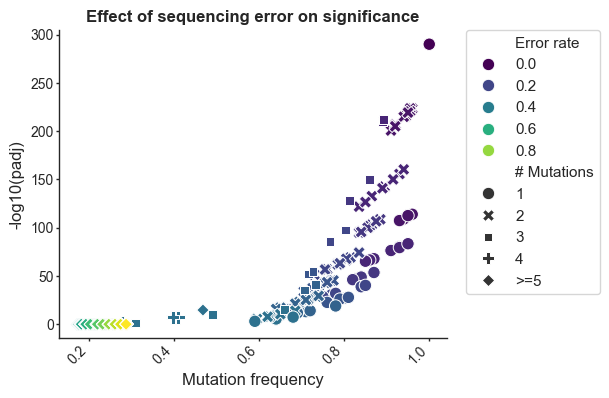

In [11]:
# We're going to make an experiment of 10 plates with different sequencing error rates
read_depth = 100
number_of_wells = 19

for position in [1, 20, 100]:
    experiment_df = pd.DataFrame()
    positions = [position]
    for sequencing_error in range(0, 100, 5):
        sequencing_error_rate = sequencing_error/100.0
        run_df = make_experiment(f'SeqError_{sequencing_error}', read_depth, sequencing_error_rate, parent_sequence, positions, parent_sequence_aa, amino_acid_to_codon, number_of_wells)
        run_df.reset_index(inplace=True)
        experiment_df = pd.concat([experiment_df, run_df])

    # Also plot each one
    experiment_df.to_csv(f'{data_dir}Experiment1_position:{position}.csv', index=False)
    experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
    experiment_df['Error rate'] = [int(c.split('_')[-1])/100.0 for c in experiment_df['Plate']]
    experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
    experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
    experiment_df = experiment_df.reset_index()
    ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Error rate', palette='viridis', 
                         style="# Mutations", style_order=['1', '2', '3', '4', '>=5'], s=80)
    set_ax_params(ax)
    plt.xlabel('Mutation frequency')
    plt.ylabel('-log10(padj)')
    plt.title('Effect of sequencing error on significance', fontsize=title_font_size, fontweight="bold")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(f'{fig_dir}Experiment1_position:{position}.svg')
    plt.show()

## Experiment 2: Varying the sequencing error rate for a multiple mutations

In [ ]:
verbose = False
for positions in [[1, 20, 100], [2, 17, 22], [50, 14, 90]]:
    experiment_df = pd.DataFrame()
    positions = positions
    number_of_wells = (19*3)  # 19 aas * 3 positions
    for sequencing_error in range(0, 100, 10):
        sequencing_error_rate = sequencing_error/100.0
        run_df = make_experiment(f'SeqError_{sequencing_error}', read_depth, sequencing_error_rate, parent_sequence, positions, 
                                 parent_sequence_aa, amino_acid_to_codon, number_of_wells)
        run_df.reset_index(inplace=True)
        experiment_df = pd.concat([experiment_df, run_df])

    # Also plot each one
    positions = [str(s) for s in positions]
    experiment_df.to_csv(f'{data_dir}Experiment2_position:{"-".join(positions)}.csv', index=False)
    experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
    experiment_df['Error rate'] = [int(c.split('_')[-1])/100.0 for c in experiment_df['Plate']]
    experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
    experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
    experiment_df = experiment_df.reset_index()
    ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Error rate', palette='viridis', 
                         style="# Mutations", style_order=['1', '2', '3', '4', '>=5'], s=80)
    set_ax_params(ax)
    plt.xlabel('Mutation frequency')
    plt.ylabel('-log10(padj)')
    plt.title('Effect of sequencing error on significance', fontsize=title_font_size, fontweight=800)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(f'{fig_dir}Experiment2_positions:{"-".join(positions)}.svg')
    plt.show()

  0%|                                                                                                                                                                                                                                 | 0/57 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/1063735736.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.905' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
  0%|                                                                                                                                                                                                                                 | 0/57 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_63705/1063735736.py:37: FutureWarning: Setting an item of incompatible dty

## Experiment 3: varying read depth and it's effect on significance (1 position)

In [ ]:
# We're going to make an experiment of 10 plates with different sequencing error rates
sequencing_error_rate = 0.1
number_of_wells = 19

for position in [1, 20, 100]:
    positions = [position]
    experiment_df = pd.DataFrame()
    for read_depth in range(5, 100, 5):
        print(sequencing_error)
        run_df = make_experiment(f'ReadDepth_{read_depth}', read_depth, sequencing_error_rate, parent_sequence, positions, parent_sequence_aa, amino_acid_to_codon, number_of_wells)
        run_df.reset_index(inplace=True)
        experiment_df = pd.concat([experiment_df, run_df])
    
     # Also plot each one
    experiment_df.to_csv(f'{data_dir}Experiment3_position:{position}.csv', index=False)
    experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
    experiment_df['Read depth'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
    experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
    experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
    experiment_df = experiment_df.reset_index()
    ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Read depth', palette='viridis', 
                         style="# Mutations", style_order=['1', '2', '3', '4', '>=5'], s=80)
    set_ax_params(ax)
    plt.xlabel('Mutation frequency')
    plt.ylabel('-log10(padj)')
    plt.title('Effect of read depth on significance', fontsize=title_font_size, fontweight="bold")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(f'{fig_dir}Experiment3_position:{position}.svg')
    plt.show()

## Experiment 4: effect of sequence length on significance


In [ ]:
# We're going to make an experiment of 10 plates with different sequencing error rates
sequencing_error_rate = 0.1
number_of_wells = 19
read_depth = 25

for position in [1, 20, 100]:
    positions = [position]
    experiment_df = pd.DataFrame()
    for seq_len in range(5, 100, 5):
        print(sequencing_error)
        run_df = make_experiment(f'SeqLen_{seq_len}', read_depth, sequencing_error_rate, parent_sequence, positions, parent_sequence_aa, amino_acid_to_codon, number_of_wells)
        run_df.reset_index(inplace=True)
        experiment_df = pd.concat([experiment_df, run_df])
    
     # Also plot each one
    experiment_df.to_csv(f'{data_dir}Experiment4_position:{position}.csv', index=False)
    experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
    experiment_df['Seq length'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
    experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
    experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
    experiment_df = experiment_df.reset_index()
    ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Seq length', palette='viridis', 
                         style="# Mutations", style_order=['1', '2', '3', '4', '>=5'], s=80)
    set_ax_params(ax)
    plt.xlabel('Mutation frequency')
    plt.ylabel('-log10(padj)')
    plt.title('Effect of sequence length on significance', fontsize=title_font_size, fontweight="bold")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(f'{fig_dir}Experiment4_position:{position}.svg')
    plt.show()